# Multiple Resistance States Model:


SS: Sensitive to both drugs
SR: Sensitive to vancomycin, resistant to linezolid
RS: Resistant to vancomycin, sensitive to linezolid
RR: Resistant to both drugs


Drug-Specific Parameters:
Seperate EC_50s for each antibiotic


Different maximum effects
Drug-specific resistance factors


Population-Specific Parameters:


Different growth rates for each resistance pattern
Different death rates
Fitness costs of resistance


Mutation Dynamics:


Different mutation rates for each drug
Stepwise mutation pathway (must acquire resistance one drug at a time)
Cross-resistance considerations

To use this model: # Run simulation
solution = simulate_resistance_dynamics(
    initial_conditions=(1e4, 1e2, 1e2, 1e1),  # SS, SR, RS, RR
    total_simulation_time=300
)

# Analyze resistance patterns
resistance_stats = analyze_resistance_patterns(so

This will show the complete simulation with:

Four bacterial populations (SS, SR, RS, RR)
Drug concentrations over time
Sequential drug administration (no drugs → vancomycin → linezolid)

Would you like to:

Adjust any of the parameters?
Modify the treatment schedule?
Analyze specific aspects of the resistance dynamics?lution)

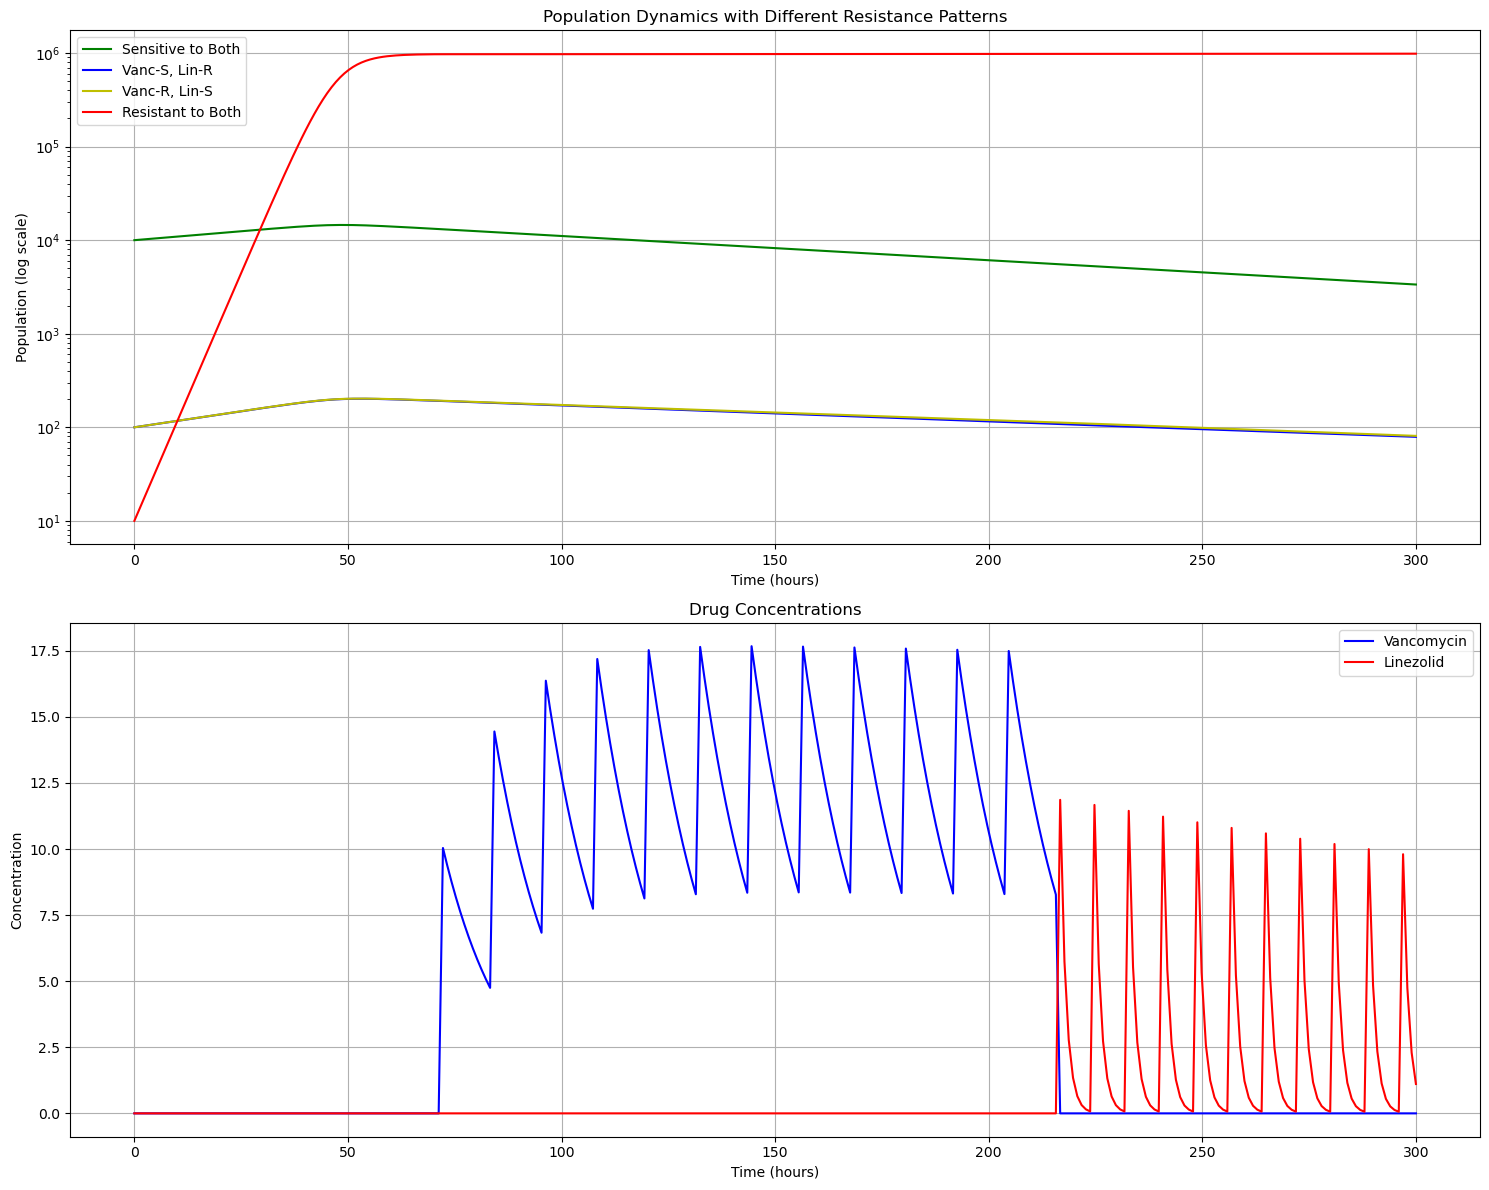

In [107]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

def concentration(t, D, V, Ke, tau, start_time, end_time, dosing_times=None):
    """Calculate drug concentration over time"""
    conc = np.zeros_like(t)
    if dosing_times is None:
        # If no specific dosing times, create regular dosing schedule
        dosing_times = np.arange(start_time, end_time, tau)
    
    for i, time_point in enumerate(t):
        if start_time <= time_point <= end_time:
            # Calculate contribution from each dose
            for dose_time in dosing_times:
                if time_point >= dose_time:
                    conc[i] += (D / V) * np.exp(-Ke * (time_point - dose_time))
    return conc

def Ke_Vancomycin(sCr, Age, weight, V=49):
    """Calculate vancomycin elimination rate"""
    eCCr = (140 - Age)*weight/(72*sCr)
    Vanco_CL = (60*eCCr)/(1000*1.08)  # l/hr
    Kel = (Vanco_CL/V)  # hr-1
    return Kel

def Ke_Linezolid(CrCL, V):
    """Calculate linezolid elimination rate"""
    CL_linezolid = 5 + (CrCL * 0.4)
    Kel = CL_linezolid / V
    return Kel

def population_ode_resistance(t, state):
    """
    State vector contains populations with different resistance patterns:
    SS: Sensitive to both drugs
    SR: Sensitive to vancomycin, Resistant to linezolid
    RS: Resistant to vancomycin, Sensitive to linezolid
    RR: Resistant to both drugs
    """
    SS, SR, RS, RR = state
    
    # Get drug concentrations at time t
    conc_vanco_t = np.interp(t, time, conc_vancomycin)
    conc_linez_t = np.interp(t, time, conc_linezolid)
    
    # Total population
    N_total = SS + SR + RS + RR
    
    # Drug effects for each drug
    vanco_effect = max_drug_effect_vanco * (conc_vanco_t / (conc_vanco_t + EC50_vanco))
    linez_effect = max_drug_effect_linez * (conc_linez_t / (conc_linez_t + EC50_linez))
    
    # Population dynamics for each subpopulation
    dSSdt = (
        SS * (
            rho_sensitive * (1 - N_total/k) *
            (1 - vanco_effect) * (1 - linez_effect) -
            delta_sensitive
        ) -
        mutation_rate_vanco * SS -  # Mutation to vancomycin resistance
        mutation_rate_linez * SS    # Mutation to linezolid resistance
    )
    
    dSRdt = (
        SR * (
            rho_partial * (1 - N_total/k) *
            (1 - vanco_effect) * (1 - resistance_factor_linez * linez_effect) -
            delta_partial
        ) +
        mutation_rate_linez * SS -  # Gained from SS mutations
        mutation_rate_vanco * SR    # Can mutate to RR
    )
    
    dRSdt = (
        RS * (
            rho_partial * (1 - N_total/k) *
            (1 - resistance_factor_vanco * vanco_effect) * (1 - linez_effect) -
            delta_partial
        ) +
        mutation_rate_vanco * SS -  # Gained from SS mutations
        mutation_rate_linez * RS    # Can mutate to RR
    )
    
    dRRdt = (
        RR * (
            rho_resistant * (1 - N_total/k) *
            (1 - resistance_factor_vanco * vanco_effect) * 
            (1 - resistance_factor_linez * linez_effect) -
            delta_resistant
        ) +
        mutation_rate_vanco * SR +  # Gained from SR mutations
        mutation_rate_linez * RS    # Gained from RS mutations
    )
    
    return [dSSdt, dSRdt, dRSdt, dRRdt]

# Drug and patient parameters
drug_params = {
    'sCr': 1.3,
    'Age': 60,
    'weight': 70,
    'V_vancomycin': 49,
    'V_linezolid': 40,
    'D_vancomycin': 500,  # mg
    'D_linezolid': 800,   # mg
    'tau_vancomycin': 12, # hours
    'tau_linezolid': 8,   # hours
}

# Model parameters
model_params = {
    # Growth rates
    'rho_sensitive': 0.015,    # Fully sensitive strain
    'rho_partial': 0.020,      # Partially resistant strains
    'rho_resistant': 0.25,    # Fully resistant strain
    
    # Death rates
    'delta_sensitive': 0.006,
    'delta_partial': 0.004,
    'delta_resistant': 0.003,
    
    # Carrying capacity
    'k': 10e5,
    
    # Drug effectiveness parameters
    'EC50_vanco': 0.03,
    'EC50_linez': 0.00000002,
    'max_drug_effect_vanco': 0.8,
    'max_drug_effect_linez': 0.999,
    
    # Resistance factors
    'resistance_factor_vanco': 0.3,
    'resistance_factor_linez': 1e-8,
    
    # Mutation rates
    'mutation_rate_vanco': 1e-6,
    'mutation_rate_linez': 1e-17,
}

def simulate_resistance_dynamics(
    initial_conditions=(1e4, 1e2, 1e2, 1e1),  # SS, SR, RS, RR
    total_simulation_time=300,
    treatment_params=None
):
    """Simulate bacterial populations with different resistance patterns"""
    if treatment_params is None:
        treatment_params = {
            'no_drug_period': 72,
            'vancomycin_duration': 6*24,
            'linezolid_duration': 8*24,
        }
    
    # Update global parameters
    globals().update(model_params)
    globals().update(drug_params)
    
    # Calculate elimination rates
    global Ke_vanco, Ke_linez
    Ke_vanco = Ke_Vancomycin(sCr, Age, weight, V_vancomycin)
    CrCL = (140 - Age)*weight / (72 * sCr)
    Ke_linez = Ke_Linezolid(CrCL, V_linezolid)
    
    # Calculate time points and drug concentrations
    global time, conc_vancomycin, conc_linezolid
    time = np.linspace(0, total_simulation_time, total_simulation_time)
    
    # Calculate drug concentrations
    conc_vancomycin = concentration(
        time, D_vancomycin, V_vancomycin, Ke_vanco, tau_vancomycin,
        treatment_params['no_drug_period'],
        treatment_params['no_drug_period'] + treatment_params['vancomycin_duration']
    )
    
    conc_linezolid = concentration(
        time, D_linezolid, V_linezolid, Ke_linez, tau_linezolid,
        treatment_params['no_drug_period'] + treatment_params['vancomycin_duration'],
        treatment_params['no_drug_period'] + treatment_params['vancomycin_duration'] + 
        treatment_params['linezolid_duration']
    )
    
    # Solve the system
    solution = solve_ivp(
        population_ode_resistance,
        [0, total_simulation_time],
        initial_conditions,
        t_eval=time,
        method='RK45',
        rtol=1e-6,
        atol=1e-6
    )
    
    # Create the plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))
    
    # Population dynamics
    ax1.semilogy(solution.t, solution.y[0], 'g-', label='Sensitive to Both')
    ax1.semilogy(solution.t, solution.y[1], 'b-', label='Vanc-S, Lin-R')
    ax1.semilogy(solution.t, solution.y[2], 'y-', label='Vanc-R, Lin-S')
    ax1.semilogy(solution.t, solution.y[3], 'r-', label='Resistant to Both')
    ax1.grid(True)
    ax1.legend()
    ax1.set_title('Population Dynamics with Different Resistance Patterns')
    ax1.set_xlabel('Time (hours)')
    ax1.set_ylabel('Population (log scale)')
    
    # Drug concentrations
    ax2.plot(time, conc_vancomycin, 'b-', label='Vancomycin')
    ax2.plot(time, conc_linezolid, 'r-', label='Linezolid')
    ax2.grid(True)
    ax2.legend()
    ax2.set_title('Drug Concentrations')
    ax2.set_xlabel('Time (hours)')
    ax2.set_ylabel('Concentration')
    
    plt.tight_layout()
    plt.show()
    
    return solution, fig

# Run the simulation
solution, fig = simulate_resistance_dynamics()

In [ ]:
solution, fig = simulate_resistance_dynamics()

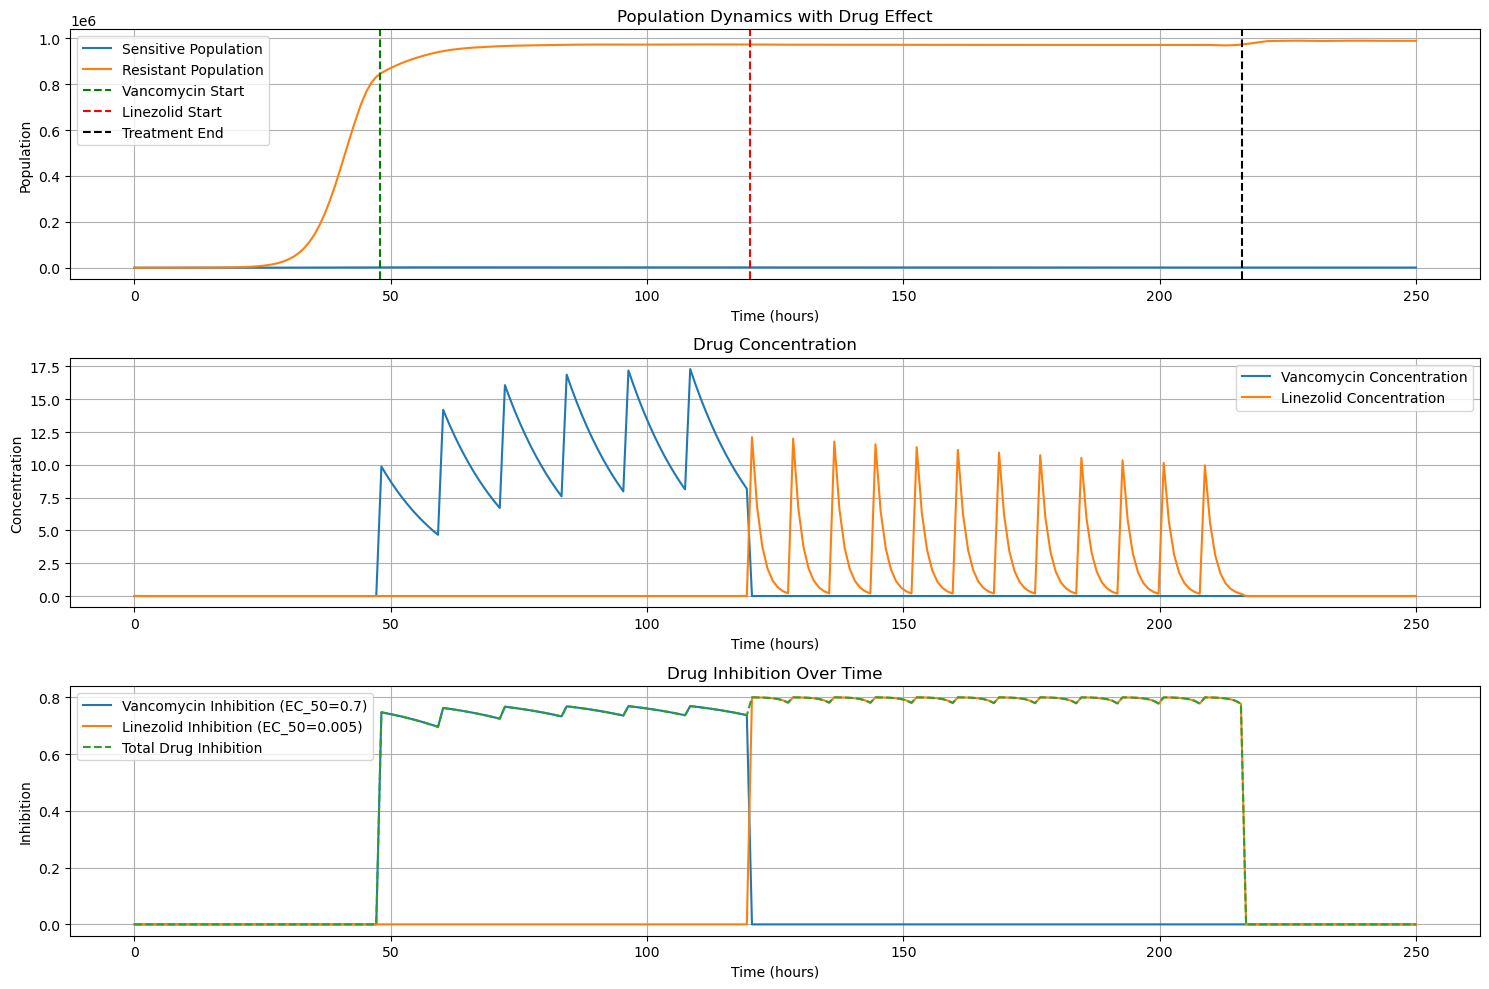

## Key Changes:

Added separate 𝐸𝐶50 values for vancomycin and linezolid: EC_50_vanco and EC_50_linez.
Calculated separate drug inhibition terms for vancomycin and linezolid.
Combined the inhibition terms to compute the total drug inhibition.
Updated the plots to show separate inhibition curves for each drug.





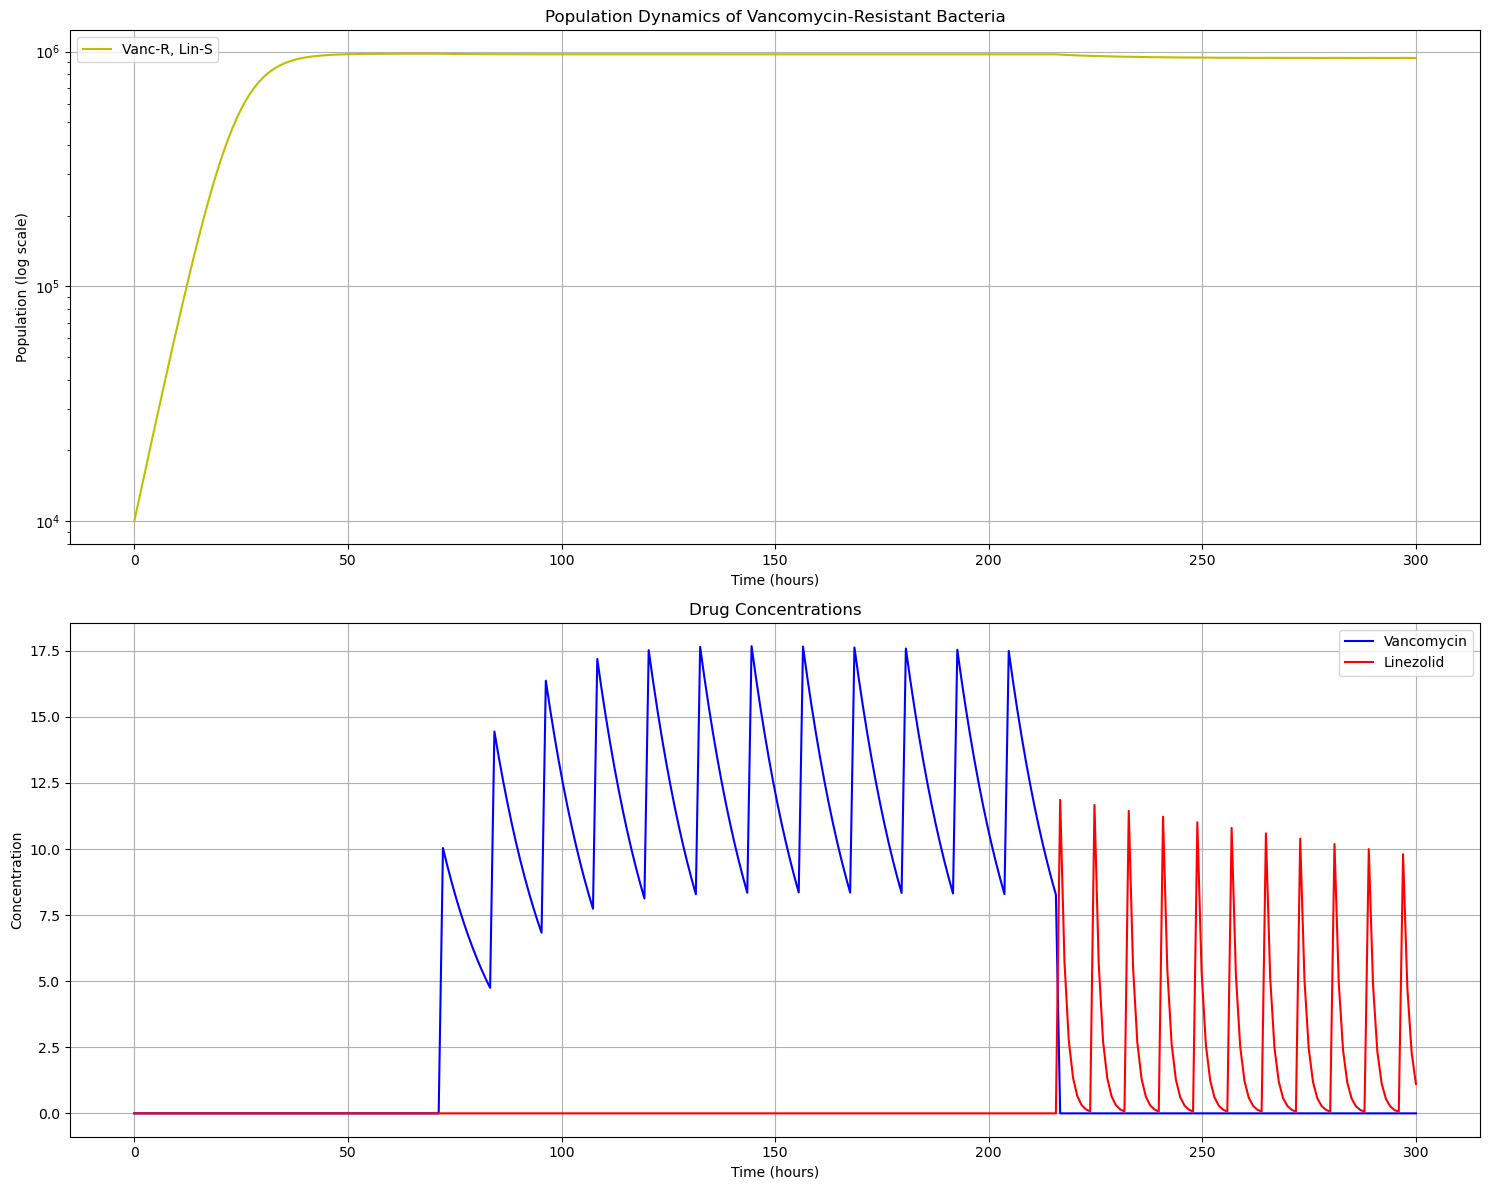

In [87]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

def concentration(t, D, V, Ke, tau, start_time, end_time, dosing_times=None):
    """Calculate drug concentration over time"""
    conc = np.zeros_like(t)
    if dosing_times is None:
        dosing_times = np.arange(start_time, end_time, tau)
    
    for i, time_point in enumerate(t):
        if start_time <= time_point <= end_time:
            for dose_time in dosing_times:
                if time_point >= dose_time:
                    conc[i] += (D / V) * np.exp(-Ke * (time_point - dose_time))
    return conc

def Ke_Vancomycin(sCr, Age, weight, V=49):
    """Calculate vancomycin elimination rate"""
    eCCr = (140 - Age)*weight/(72*sCr)
    Vanco_CL = (60*eCCr)/(1000*1.08)  # l/hr
    Kel = (Vanco_CL/V)  # hr-1
    return Kel

def Ke_Linezolid(CrCL, V):
    """Calculate linezolid elimination rate"""
    CL_linezolid = 5 + (CrCL * 0.4)
    Kel = CL_linezolid / V
    return Kel

def population_ode_resistance(t, state):
    """
    State vector contains population:
    R: Resistant to vancomycin, Sensitive to linezolid
    """
    R = state[0]
    
    # Get drug concentrations at time t
    conc_vanco_t = np.interp(t, time, conc_vancomycin)
    conc_linez_t = np.interp(t, time, conc_linezolid)
    
    # Drug effects
    vanco_effect = max_drug_effect_vanco * (conc_vanco_t / (conc_vanco_t + EC50_vanco))
    linez_effect = max_drug_effect_linez * (conc_linez_t / (conc_linez_t + EC50_linez))
    
    # Population dynamics
    dRdt = R * (
        rho * (1 - R/k) *
        (1 - resistance_factor_vanco * vanco_effect) * 
        (1 - linez_effect) -
        delta
    )
    
    return [dRdt]

# Drug and patient parameters
drug_params = {
    'sCr': 1.3,
    'Age': 60,
    'weight': 70,
    'V_vancomycin': 49,
    'V_linezolid': 40,
    'D_vancomycin': 500,  # mg
    'D_linezolid': 800,   # mg
    'tau_vancomycin': 12, # hours
    'tau_linezolid': 8,   # hours
}

# Model parameters
model_params = {
    # Growth rate
    'rho': 0.20,      # Growth rate of resistant strain
    
    # Death rate
    'delta': 0.004,   # Natural death rate
    
    # Carrying capacity
    'k': 10e5,
    
    # Drug effectiveness parameters
    'EC50_vanco': 0.03,
    'EC50_linez': 0.02,
    'max_drug_effect_vanco': 0.8,
    'max_drug_effect_linez': 0.7,
    
    # Resistance factor
    'resistance_factor_vanco': 0.3,  # Reduced effect of vancomycin due to resistance
}

def simulate_resistance_dynamics(
    initial_condition=1e4,  # Initial resistant population
    total_simulation_time=300,
    treatment_params=None
):
    """Simulate bacterial population with vancomycin resistance"""
    if treatment_params is None:
        treatment_params = {
            'no_drug_period': 72,
            'vancomycin_duration': 6*24,
            'linezolid_duration': 8*24,
        }
    
    # Update global parameters
    globals().update(model_params)
    globals().update(drug_params)
    
    # Calculate elimination rates
    global Ke_vanco, Ke_linez
    Ke_vanco = Ke_Vancomycin(sCr, Age, weight, V_vancomycin)
    CrCL = (140 - Age)*weight / (72 * sCr)
    Ke_linez = Ke_Linezolid(CrCL, V_linezolid)
    
    # Calculate time points and drug concentrations
    global time, conc_vancomycin, conc_linezolid
    time = np.linspace(0, total_simulation_time, total_simulation_time)
    
    # Calculate drug concentrations
    conc_vancomycin = concentration(
        time, D_vancomycin, V_vancomycin, Ke_vanco, tau_vancomycin,
        treatment_params['no_drug_period'],
        treatment_params['no_drug_period'] + treatment_params['vancomycin_duration']
    )
    
    conc_linezolid = concentration(
        time, D_linezolid, V_linezolid, Ke_linez, tau_linezolid,
        treatment_params['no_drug_period'] + treatment_params['vancomycin_duration'],
        treatment_params['no_drug_period'] + treatment_params['vancomycin_duration'] + 
        treatment_params['linezolid_duration']
    )
    
    # Solve the system
    solution = solve_ivp(
        population_ode_resistance,
        [0, total_simulation_time],
        [initial_condition],
        t_eval=time,
        method='RK45',
        rtol=1e-6,
        atol=1e-6
    )
    
    # Create the plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))
    
    # Population dynamics
    ax1.semilogy(solution.t, solution.y[0], 'y-', label='Vanc-R, Lin-S')
    ax1.grid(True)
    ax1.legend()
    ax1.set_title('Population Dynamics of Vancomycin-Resistant Bacteria')
    ax1.set_xlabel('Time (hours)')
    ax1.set_ylabel('Population (log scale)')
    
    # Drug concentrations
    ax2.plot(time, conc_vancomycin, 'b-', label='Vancomycin')
    ax2.plot(time, conc_linezolid, 'r-', label='Linezolid')
    ax2.grid(True)
    ax2.legend()
    ax2.set_title('Drug Concentrations')
    ax2.set_xlabel('Time (hours)')
    ax2.set_ylabel('Concentration')
    
    plt.tight_layout()
    plt.show()
    
    return solution, fig

# Run the simulation
solution, fig = simulate_resistance_dynamics()

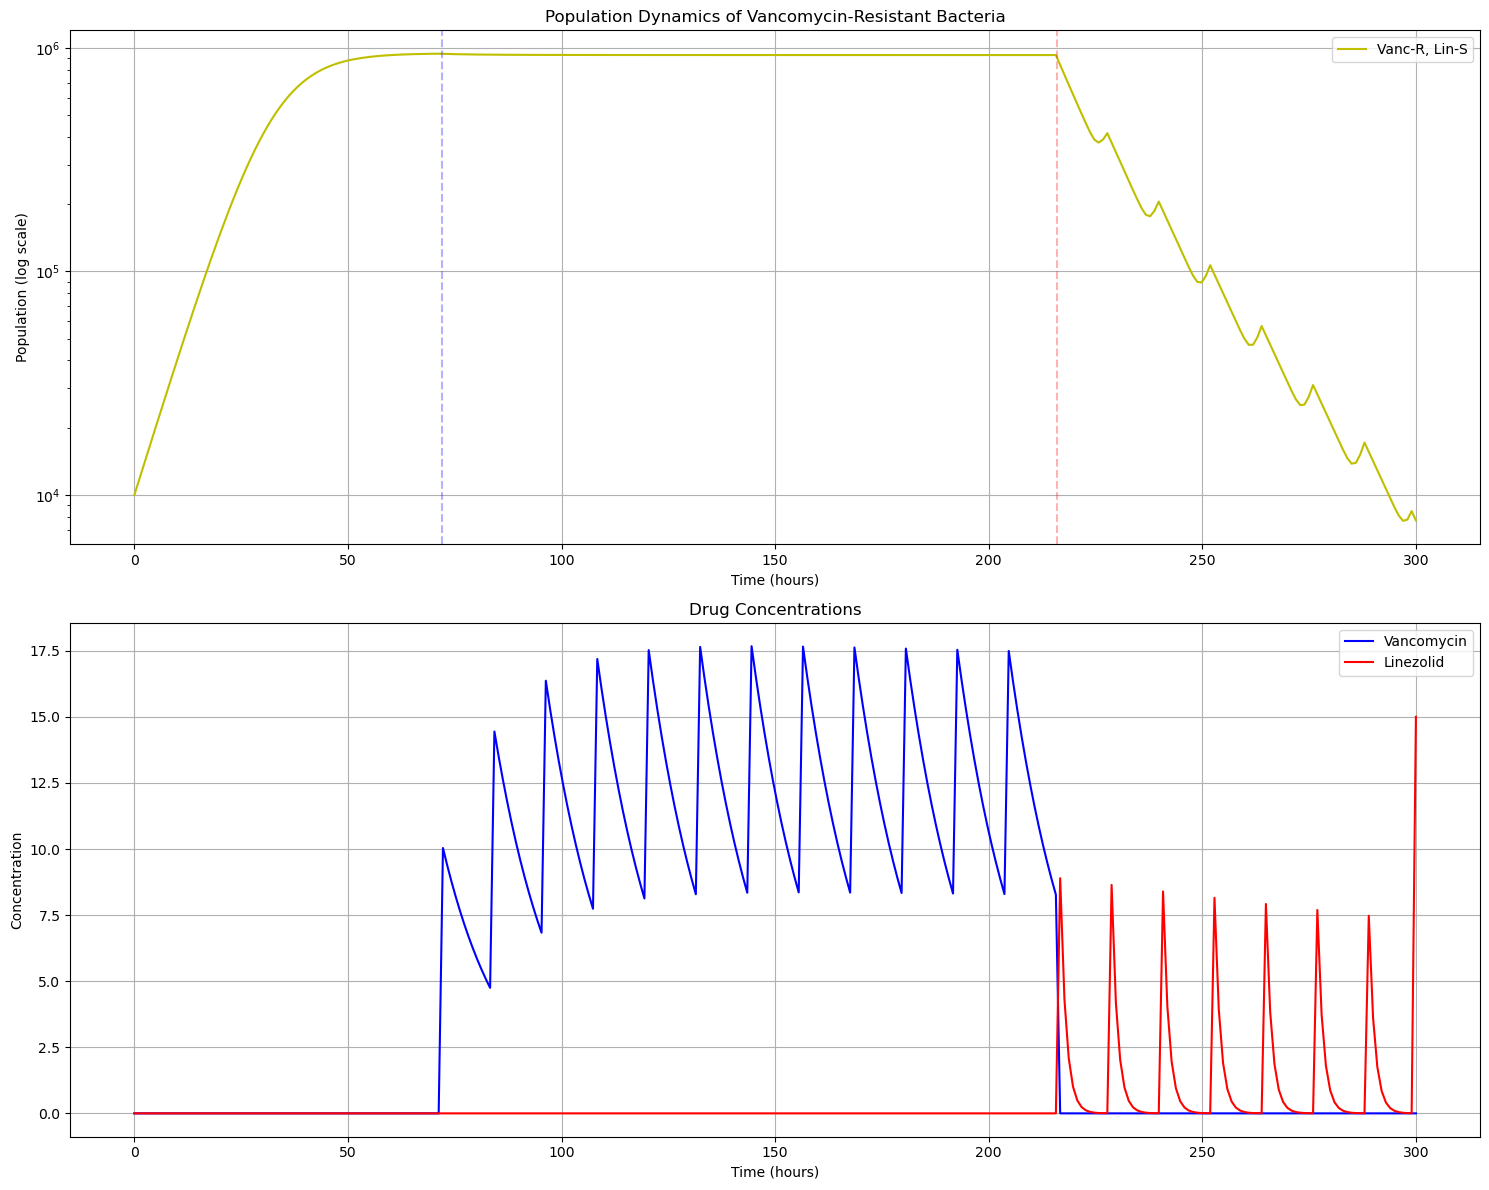

In [89]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Previous functions remain the same
def concentration(t, D, V, Ke, tau, start_time, end_time, dosing_times=None):
    """Calculate drug concentration over time"""
    conc = np.zeros_like(t)
    if dosing_times is None:
        dosing_times = np.arange(start_time, end_time, tau)
    
    for i, time_point in enumerate(t):
        if start_time <= time_point <= end_time:
            for dose_time in dosing_times:
                if time_point >= dose_time:
                    conc[i] += (D / V) * np.exp(-Ke * (time_point - dose_time))
    return conc

def Ke_Vancomycin(sCr, Age, weight, V=49):
    """Calculate vancomycin elimination rate"""
    eCCr = (140 - Age)*weight/(72*sCr)
    Vanco_CL = (60*eCCr)/(1000*1.08)  # l/hr
    Kel = (Vanco_CL/V)  # hr-1
    return Kel

def Ke_Linezolid(CrCL, V):
    """Calculate linezolid elimination rate"""
    CL_linezolid = 5 + (CrCL * 0.4)
    Kel = CL_linezolid / V
    return Kel

def population_ode_resistance(t, state):
    """
    State vector contains population:
    R: Resistant to vancomycin, Sensitive to linezolid
    """
    R = state[0]
    
    # Get drug concentrations at time t
    conc_vanco_t = np.interp(t, time, conc_vancomycin)
    conc_linez_t = np.interp(t, time, conc_linezolid)
    
    # Drug effects with enhanced linezolid killing
    vanco_effect = max_drug_effect_vanco * (conc_vanco_t / (conc_vanco_t + EC50_vanco))
    linez_effect = max_drug_effect_linez * (conc_linez_t**hill_coeff / (conc_linez_t**hill_coeff + EC50_linez**hill_coeff))
    
    # Modified population dynamics with enhanced killing effect
    dRdt = R * (
        rho * (1 - R/k) *
        (1 - resistance_factor_vanco * vanco_effect) * 
        (1 - linez_effect) -
        delta -
        (killing_rate_linez * linez_effect)  # Added explicit killing term
    )
    
    return [dRdt]

# Drug and patient parameters
drug_params = {
    'sCr': 1.3,
    'Age': 60,
    'weight': 70,
    'V_vancomycin': 49,
    'V_linezolid': 40,
    'D_vancomycin': 500,  # mg
    'D_linezolid': 600,   # mg
    'tau_vancomycin': 12, # hours
    'tau_linezolid': 12,  # hours
}

# Updated model parameters for enhanced linezolid effect
model_params = {
    # Growth rate
    'rho': 0.15,      # Reduced growth rate
    
    # Death rate
    'delta': 0.008,   # Increased natural death rate
    
    # Carrying capacity
    'k': 10e5,
    
    # Drug effectiveness parameters
    'EC50_vanco': 0.03,
    'EC50_linez': 0.015,  # Reduced EC50 for linezolid (increased potency)
    'max_drug_effect_vanco': 0.8,
    'max_drug_effect_linez': 0.95,  # Increased maximum effect
    'hill_coeff': 2.0,    # Hill coefficient for steeper concentration-effect relationship
    'killing_rate_linez': 0.1,  # Explicit killing rate for linezolid
    
    # Resistance factor
    'resistance_factor_vanco': 0.3,
}

def simulate_resistance_dynamics(
    initial_condition=1e4,
    total_simulation_time=300,
    treatment_params=None
):
    """Simulate bacterial population with vancomycin resistance"""
    if treatment_params is None:
        treatment_params = {
            'no_drug_period': 72,
            'vancomycin_duration': 6*24,
            'linezolid_duration': 8*24,
        }
    
    # Update global parameters
    globals().update(model_params)
    globals().update(drug_params)
    
    # Calculate elimination rates
    global Ke_vanco, Ke_linez
    Ke_vanco = Ke_Vancomycin(sCr, Age, weight, V_vancomycin)
    CrCL = (140 - Age)*weight / (72 * sCr)
    Ke_linez = Ke_Linezolid(CrCL, V_linezolid)
    
    # Calculate time points and drug concentrations
    global time, conc_vancomycin, conc_linezolid
    time = np.linspace(0, total_simulation_time, total_simulation_time)
    
    # Calculate drug concentrations
    conc_vancomycin = concentration(
        time, D_vancomycin, V_vancomycin, Ke_vanco, tau_vancomycin,
        treatment_params['no_drug_period'],
        treatment_params['no_drug_period'] + treatment_params['vancomycin_duration']
    )
    
    conc_linezolid = concentration(
        time, D_linezolid, V_linezolid, Ke_linez, tau_linezolid,
        treatment_params['no_drug_period'] + treatment_params['vancomycin_duration'],
        treatment_params['no_drug_period'] + treatment_params['vancomycin_duration'] + 
        treatment_params['linezolid_duration']
    )
    
    # Solve the system
    solution = solve_ivp(
        population_ode_resistance,
        [0, total_simulation_time],
        [initial_condition],
        t_eval=time,
        method='RK45',
        rtol=1e-6,
        atol=1e-6
    )
    
    # Create the plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))
    
    # Population dynamics
    ax1.semilogy(solution.t, solution.y[0], 'y-', label='Vanc-R, Lin-S')
    ax1.grid(True)
    ax1.legend()
    ax1.set_title('Population Dynamics of Vancomycin-Resistant Bacteria')
    ax1.set_xlabel('Time (hours)')
    ax1.set_ylabel('Population (log scale)')
    
    # Add vertical lines for treatment periods
    ax1.axvline(x=treatment_params['no_drug_period'], color='b', linestyle='--', alpha=0.3)
    ax1.axvline(x=treatment_params['no_drug_period'] + treatment_params['vancomycin_duration'], 
                color='r', linestyle='--', alpha=0.3)
    
    # Drug concentrations
    ax2.plot(time, conc_vancomycin, 'b-', label='Vancomycin')
    ax2.plot(time, conc_linezolid, 'r-', label='Linezolid')
    ax2.grid(True)
    ax2.legend()
    ax2.set_title('Drug Concentrations')
    ax2.set_xlabel('Time (hours)')
    ax2.set_ylabel('Concentration')
    
    plt.tight_layout()
    plt.show()
    
    return solution, fig

# Run the simulation
solution, fig = simulate_resistance_dynamics()

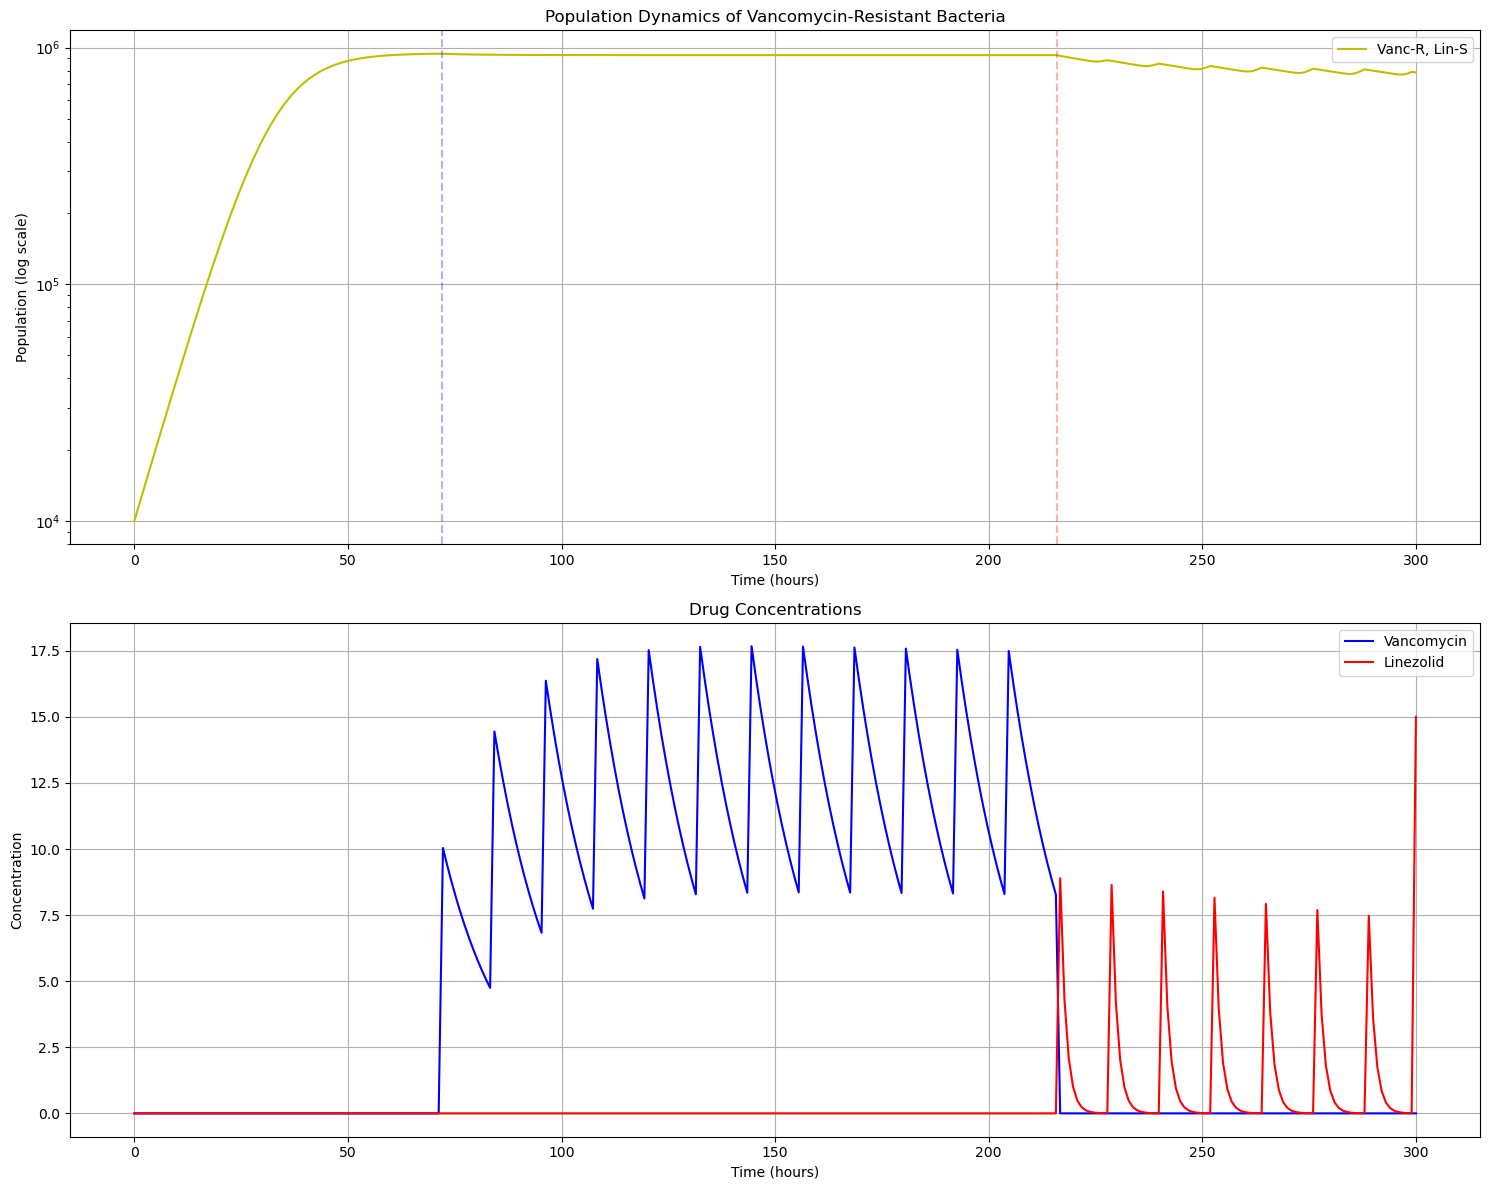

In [109]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Previous concentration and Ke functions remain the same
def concentration(t, D, V, Ke, tau, start_time, end_time, dosing_times=None):
    """Calculate drug concentration over time"""
    conc = np.zeros_like(t)
    if dosing_times is None:
        dosing_times = np.arange(start_time, end_time, tau)
    
    for i, time_point in enumerate(t):
        if start_time <= time_point <= end_time:
            for dose_time in dosing_times:
                if time_point >= dose_time:
                    conc[i] += (D / V) * np.exp(-Ke * (time_point - dose_time))
    return conc

def Ke_Vancomycin(sCr, Age, weight, V=49):
    """Calculate vancomycin elimination rate"""
    eCCr = (140 - Age)*weight/(72*sCr)
    Vanco_CL = (60*eCCr)/(1000*1.08)  # l/hr
    Kel = (Vanco_CL/V)  # hr-1
    return Kel

def Ke_Linezolid(CrCL, V):
    """Calculate linezolid elimination rate"""
    CL_linezolid = 5 + (CrCL * 0.4)
    Kel = CL_linezolid / V
    return Kel

def population_ode_resistance(t, state):
    """
    State vector contains population:
    R: Resistant to vancomycin, Sensitive to linezolid
    """
    R = state[0]
    
    # Get drug concentrations at time t
    conc_vanco_t = np.interp(t, time, conc_vancomycin)
    conc_linez_t = np.interp(t, time, conc_linezolid)
    
    # Drug effects with Hill equation for linezolid
    vanco_effect = max_drug_effect_vanco * (conc_vanco_t / (conc_vanco_t + EC50_vanco))
    linez_effect = max_drug_effect_linez * (conc_linez_t**hill_coeff / (conc_linez_t**hill_coeff + EC50_linez**hill_coeff))
    
    # Population dynamics without explicit killing
    dRdt = R * (
        rho * (1 - R/k) *
        (1 - resistance_factor_vanco * vanco_effect) * 
        (1 - linez_effect) -
        delta
    )
    
    return [dRdt]

# Drug and patient parameters
drug_params = {
    'sCr': 1.3,
    'Age': 60,
    'weight': 70,
    'V_vancomycin': 49,
    'V_linezolid': 40,
    'D_vancomycin': 500,  # mg
    'D_linezolid': 600,   # mg
    'tau_vancomycin': 12, # hours
    'tau_linezolid': 12,  # hours
}

# Updated model parameters without killing rate
model_params = {
    # Growth rate
    'rho': 0.15,      
    
    # Death rate
    'delta': 0.008,   
    
    # Carrying capacity
    'k': 10e5,
    
    # Drug effectiveness parameters
    'EC50_vanco': 0.03,
    'EC50_linez': 0.015,  
    'max_drug_effect_vanco': 0.8,
    'max_drug_effect_linez': 0.95,  
    'hill_coeff': 2.0,    
    
    # Resistance factor
    'resistance_factor_vanco': 0.3,
}

def simulate_resistance_dynamics(
    initial_condition=1e4,
    total_simulation_time=300,
    treatment_params=None
):
    """Simulate bacterial population with vancomycin resistance"""
    if treatment_params is None:
        treatment_params = {
            'no_drug_period': 72,
            'vancomycin_duration': 6*24,
            'linezolid_duration': 8*24,
        }
    
    # Update global parameters
    globals().update(model_params)
    globals().update(drug_params)
    
    # Calculate elimination rates
    global Ke_vanco, Ke_linez
    Ke_vanco = Ke_Vancomycin(sCr, Age, weight, V_vancomycin)
    CrCL = (140 - Age)*weight / (72 * sCr)
    Ke_linez = Ke_Linezolid(CrCL, V_linezolid)
    
    # Calculate time points and drug concentrations
    global time, conc_vancomycin, conc_linezolid
    time = np.linspace(0, total_simulation_time, total_simulation_time)
    
    # Calculate drug concentrations
    conc_vancomycin = concentration(
        time, D_vancomycin, V_vancomycin, Ke_vanco, tau_vancomycin,
        treatment_params['no_drug_period'],
        treatment_params['no_drug_period'] + treatment_params['vancomycin_duration']
    )
    
    conc_linezolid = concentration(
        time, D_linezolid, V_linezolid, Ke_linez, tau_linezolid,
        treatment_params['no_drug_period'] + treatment_params['vancomycin_duration'],
        treatment_params['no_drug_period'] + treatment_params['vancomycin_duration'] + 
        treatment_params['linezolid_duration']
    )
    
    # Solve the system
    solution = solve_ivp(
        population_ode_resistance,
        [0, total_simulation_time],
        [initial_condition],
        t_eval=time,
        method='RK45',
        rtol=1e-6,
        atol=1e-6
    )
    
    # Create the plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))
    
    # Population dynamics
    ax1.semilogy(solution.t, solution.y[0], 'y-', label='Vanc-R, Lin-S')
    ax1.grid(True)
    ax1.legend()
    ax1.set_title('Population Dynamics of Vancomycin-Resistant Bacteria')
    ax1.set_xlabel('Time (hours)')
    ax1.set_ylabel('Population (log scale)')
    
    # Add vertical lines for treatment periods
    ax1.axvline(x=treatment_params['no_drug_period'], color='b', linestyle='--', alpha=0.3)
    ax1.axvline(x=treatment_params['no_drug_period'] + treatment_params['vancomycin_duration'], 
                color='r', linestyle='--', alpha=0.3)
    
    # Drug concentrations
    ax2.plot(time, conc_vancomycin, 'b-', label='Vancomycin')
    ax2.plot(time, conc_linezolid, 'r-', label='Linezolid')
    ax2.grid(True)
    ax2.legend()
    ax2.set_title('Drug Concentrations')
    ax2.set_xlabel('Time (hours)')
    ax2.set_ylabel('Concentration')
    
    plt.tight_layout()
    plt.show()
    
    return solution, fig

# Run the simulation
solution, fig = simulate_resistance_dynamics()


Key points in the solution:
Initial conditions:
Sensitive bacteria: 2.00
Resistant bacteria: 5.00

At the start of vancomycin treatment (t=48h):
Sensitive bacteria: 87227.54
Resistant bacteria: 799339.17

At the end of vancomycin treatment (t=120h):
Sensitive bacteria: 12623.37
Resistant bacteria: 954256.03

At the end of linezolid treatment (t=216h):
Sensitive bacteria: 847.94
Resistant bacteria: 974658.85


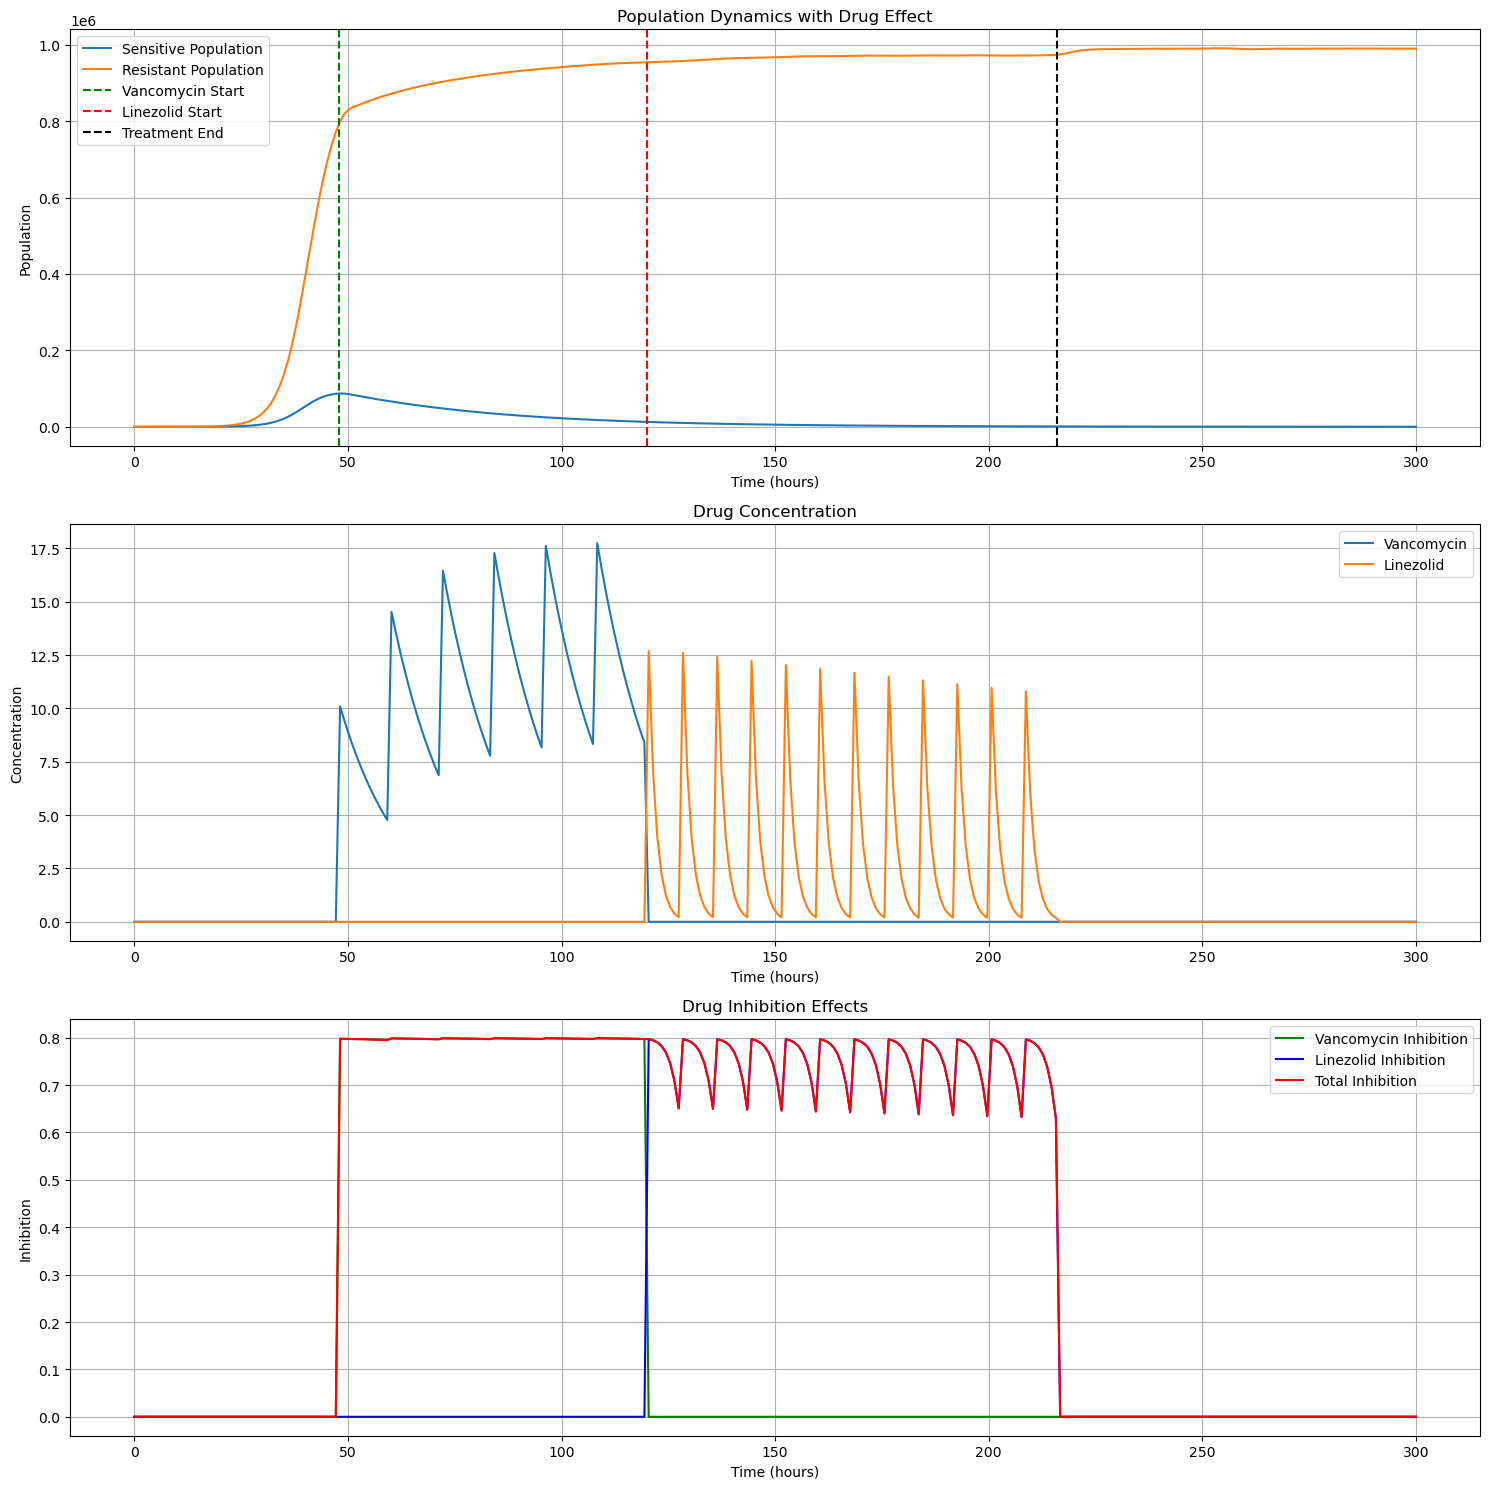

In [111]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt 

def Ke_Vancomycin(sCr, Age, weight, V=49):
    eCCr = (140 - Age)*weight/(72*sCr)
    Vanco_CL = (60*eCCr)/(1000*1.08)  # l/hr
    Kel = (Vanco_CL/V)  # hr-1
    return Kel

def Ke_Linezolid(sCr, Age, weight, V=50):
    CrCL = (140 - Age)*weight/(72*sCr)
    CL_linezolid = 5 + (CrCL * 0.4)
    Kel = CL_linezolid / V
    return Kel

def concentration(t, D, V, Ke, tau, start_time, end_time, dosing_times=None):
    conc = np.zeros_like(t)
    if dosing_times is None:
        dosing_times = np.arange(start_time, end_time, tau)
    
    for i, time_point in enumerate(t):
        if start_time <= time_point <= end_time:
            for dose_time in dosing_times:
                if time_point >= dose_time:
                    conc[i] += (D / V) * np.exp(-Ke * (time_point - dose_time))
    return conc

def simulate_drug_dynamics(
    initial_sensitive=2, 
    initial_resistant=5, 
    no_drug_period=48,
    vancomycin_duration=72,
    linezolid_duration=96,
    total_simulation_time=300
):
    # First, calculate all timing to ensure it fits
    vanco_start = no_drug_period
    vanco_end = vanco_start + vancomycin_duration
    linez_start = vanco_end
    linez_end = linez_start + linezolid_duration
    
    # Verify timing fits within simulation
    if linez_end > total_simulation_time:
        raise ValueError(f"Total treatment time ({linez_end}h) exceeds simulation time ({total_simulation_time}h)")

    # Patient Specific Parameters
    sCr = 1.3
    Age = 60
    weight = 70
    V_vancomycin = 49
    V_linezolid = 50

    # Calculate Elimination Rates
    Ke_vanco = Ke_Vancomycin(sCr, Age, weight)
    Ke_linez = Ke_Linezolid(sCr, Age, weight)

    # Time Array
    time = np.linspace(0, total_simulation_time, total_simulation_time)

    # Vancomycin Dosing
    D_vancomycin = 500  # mg
    tau_vancomycin = 12  # hours

    # Linezolid Dosing
    D_linezolid = 800  # mg
    tau_linezolid = 8  # hours

    # Calculate Drug Concentrations
    conc_vancomycin = concentration(
        time, D_vancomycin, V_vancomycin, Ke_vanco, tau_vancomycin, 
        vanco_start, vanco_end
    )
    conc_linezolid = concentration(
        time, D_linezolid, V_linezolid, Ke_linez, tau_linezolid, 
        linez_start, linez_end
    )

    # Population Dynamics Parameters
    rho_sensitive = 0.3
    rho_resistant = 0.3
    k = 10e5  # carry capacity
    EC_50_vanco = 0.03  # EC50 for vancomycin
    EC_50_linez = 0.05  # EC50 for linezolid
    max_drug_effect = 0.8
    delta_sensitive = 0.03
    delta_resistant = 0.003

    def population_ode(t, r):
        S, R = r
        
        # Get individual drug concentrations at time t
        vanco_t = np.interp(t, time, conc_vancomycin)
        linez_t = np.interp(t, time, conc_linezolid)
        
        # Calculate drug inhibition for each drug
        vanco_inhibition = max_drug_effect * (vanco_t / (vanco_t + EC_50_vanco))
        linez_inhibition = max_drug_effect * (linez_t / (linez_t + EC_50_linez))
        
        # Total drug effect is the sum of individual effects, capped at max_drug_effect
        total_drug_inhibition = np.minimum(vanco_inhibition + linez_inhibition, max_drug_effect)
        
        # Growth terms - allow growth during antibiotic-free period
        if t < vanco_start:  # During antibiotic-free period
            dSdt = rho_sensitive * S * (1 - (S + R) / k) - delta_sensitive * S
            dRdt = rho_resistant * R * (1 - (S + R) / k) - delta_resistant * R
        else:  # During antibiotic treatment
            dSdt = rho_sensitive * S * (1 - (S + R) / k) * (1 - total_drug_inhibition) - delta_sensitive * S
            dRdt = rho_resistant * R * (1 - (S + R) / k) * (1 - 0.8 * total_drug_inhibition) - delta_resistant * R
        
        return [dSdt, dRdt]

    solution = solve_ivp(
        population_ode, 
        [0, total_simulation_time], 
        [initial_sensitive, initial_resistant],
        dense_output=True,
        t_eval=time
    )

    # Calculate combined drug inhibition over time
    vanco_inhibition = max_drug_effect * (conc_vancomycin / (conc_vancomycin + EC_50_vanco))
    linez_inhibition = max_drug_effect * (conc_linezolid / (conc_linezolid + EC_50_linez))
    drug_inhibition = np.minimum(vanco_inhibition + linez_inhibition, max_drug_effect)

    # Print key points in the solution
    print("\nKey points in the solution:")
    print(f"Initial conditions:")
    print(f"Sensitive bacteria: {solution.y[0][0]:.2f}")
    print(f"Resistant bacteria: {solution.y[1][0]:.2f}")
    
    print(f"\nAt the start of vancomycin treatment (t={vanco_start}h):")
    idx_vanco = np.where(time >= vanco_start)[0][0]
    print(f"Sensitive bacteria: {solution.y[0][idx_vanco]:.2f}")
    print(f"Resistant bacteria: {solution.y[1][idx_vanco]:.2f}")
    
    print(f"\nAt the end of vancomycin treatment (t={vanco_end}h):")
    idx_vanco_end = np.where(time >= vanco_end)[0][0]
    print(f"Sensitive bacteria: {solution.y[0][idx_vanco_end]:.2f}")
    print(f"Resistant bacteria: {solution.y[1][idx_vanco_end]:.2f}")
    
    print(f"\nAt the end of linezolid treatment (t={linez_end}h):")
    idx_linez_end = np.where(time >= linez_end)[0][0]
    print(f"Sensitive bacteria: {solution.y[0][idx_linez_end]:.2f}")
    print(f"Resistant bacteria: {solution.y[1][idx_linez_end]:.2f}")

    plt.figure(figsize=(15, 15))
    
    # Population dynamics plot
    plt.subplot(3, 1, 1)
    plt.plot(time, solution.y[0], label='Sensitive Population')
    plt.plot(time, solution.y[1], label='Resistant Population')
    plt.axvline(x=vanco_start, color='g', linestyle='--', label='Vancomycin Start')
    plt.axvline(x=vanco_end, color='r', linestyle='--', label='Linezolid Start')
    plt.axvline(x=linez_end, color='k', linestyle='--', label='Treatment End')
    plt.title('Population Dynamics with Drug Effect')
    plt.xlabel('Time (hours)')
    plt.ylabel('Population')
    plt.legend()
    plt.grid(True)

    # Drug concentration plot
    plt.subplot(3, 1, 2)
    plt.plot(time, conc_vancomycin, label='Vancomycin')
    plt.plot(time, conc_linezolid, label='Linezolid')
    plt.title('Drug Concentration')
    plt.xlabel('Time (hours)')
    plt.ylabel('Concentration')
    plt.legend()
    plt.grid(True)

    # Drug inhibition plot
    plt.subplot(3, 1, 3)
    plt.plot(time, vanco_inhibition, 'g-', label='Vancomycin Inhibition')
    plt.plot(time, linez_inhibition, 'b-', label='Linezolid Inhibition')
    plt.plot(time, drug_inhibition, 'r-', label='Total Inhibition')
    plt.title('Drug Inhibition Effects')
    plt.xlabel('Time (hours)')
    plt.ylabel('Inhibition')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    
    return solution, time, conc_vancomycin, conc_linezolid, drug_inhibition

# Run the simulation
solution, time, conc_vanco, conc_linez, drug_inhibition = simulate_drug_dynamics()


Key points in the solution:
Initial conditions:
Sensitive bacteria: 2.00
Resistant bacteria: 5.00

At the start of vancomycin treatment (t=48h):
Sensitive bacteria: 86893.96
Resistant bacteria: 797612.39

At the end of vancomycin treatment (t=120h):
Sensitive bacteria: 11083.73
Resistant bacteria: 975142.25

At the end of linezolid treatment (t=216h):
Sensitive bacteria: 768.70
Resistant bacteria: 973734.91


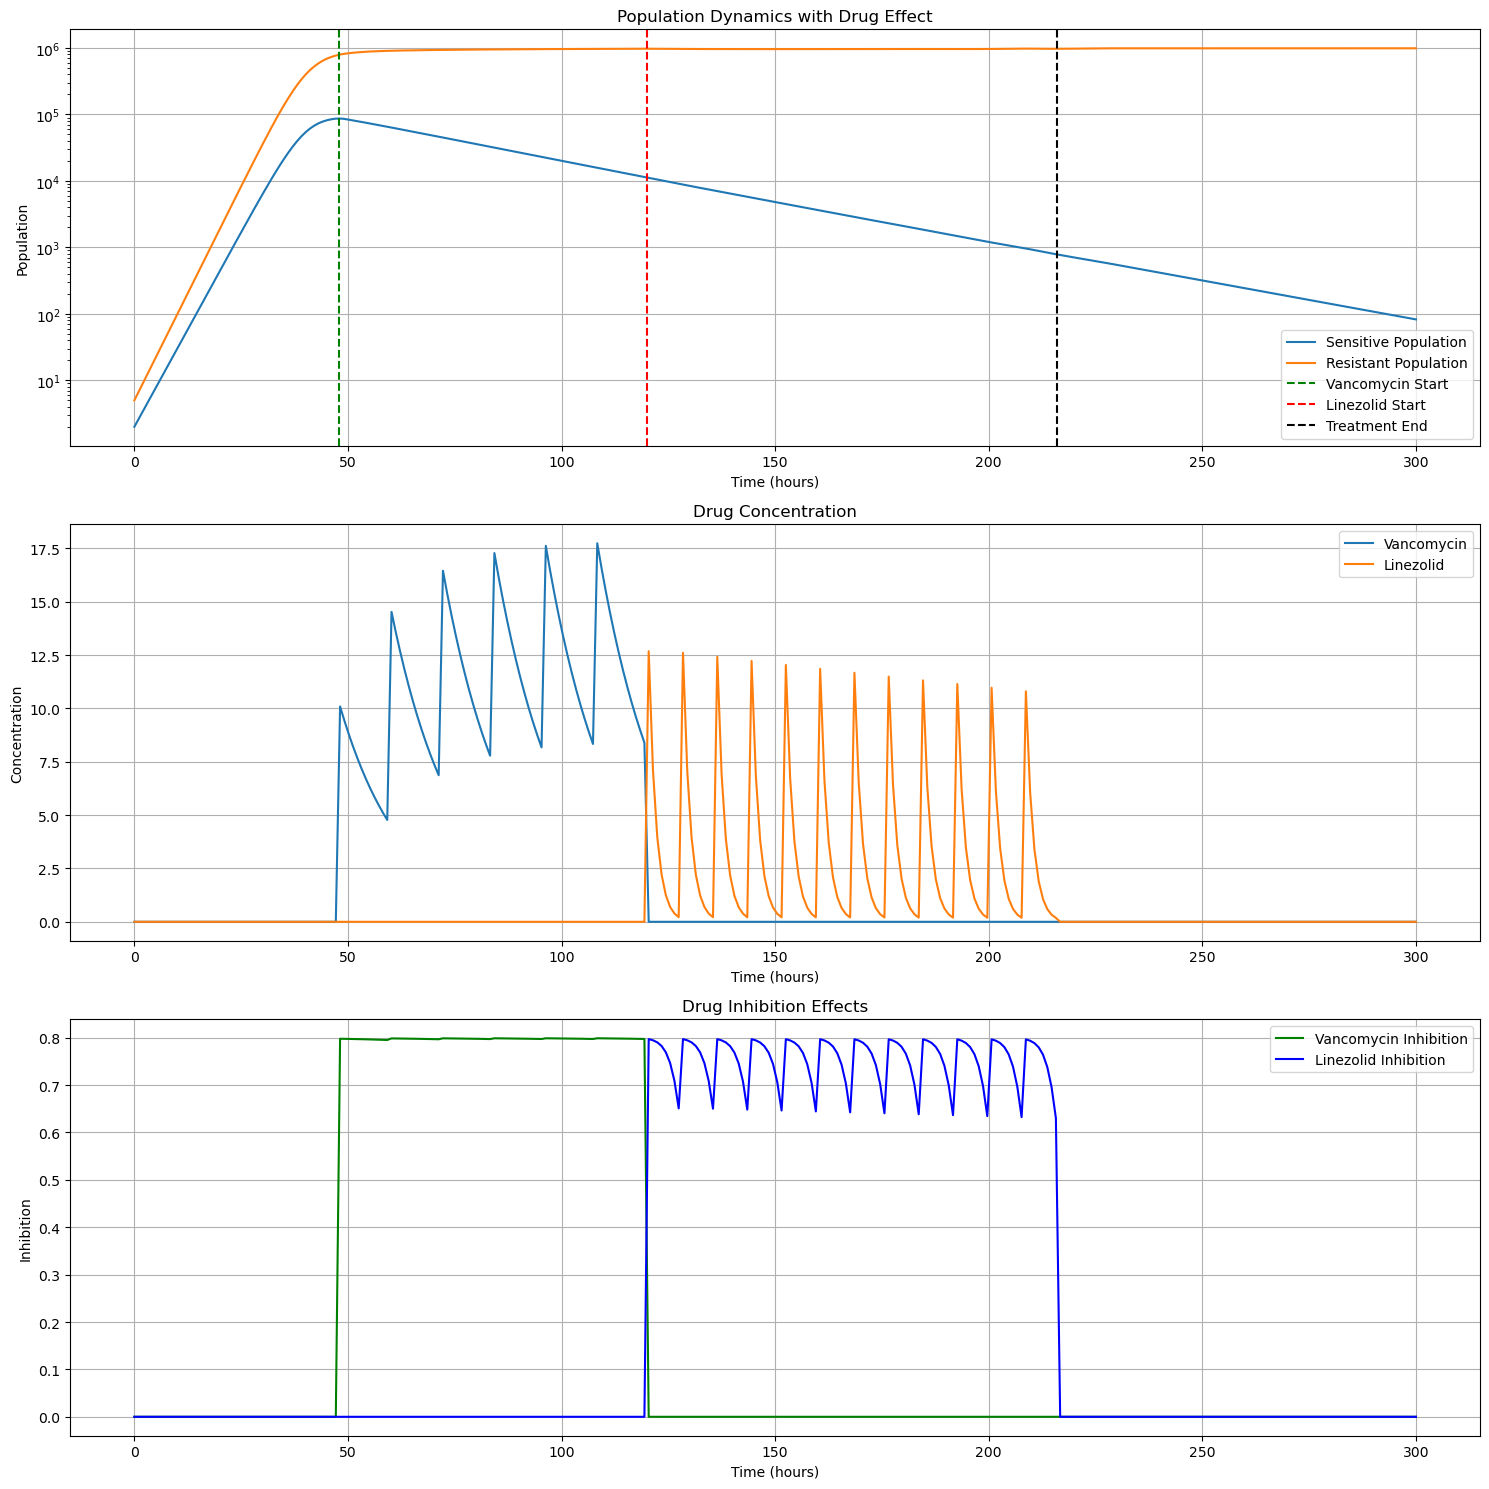

In [113]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt 

def Ke_Vancomycin(sCr, Age, weight, V=49):
    eCCr = (140 - Age)*weight/(72*sCr)
    Vanco_CL = (60*eCCr)/(1000*1.08)  # l/hr
    Kel = (Vanco_CL/V)  # hr-1
    return Kel

def Ke_Linezolid(sCr, Age, weight, V=50):
    CrCL = (140 - Age)*weight/(72*sCr)
    CL_linezolid = 5 + (CrCL * 0.4)
    Kel = CL_linezolid / V
    return Kel

def concentration(t, D, V, Ke, tau, start_time, end_time, dosing_times=None):
    conc = np.zeros_like(t)
    if dosing_times is None:
        dosing_times = np.arange(start_time, end_time, tau)
    
    for i, time_point in enumerate(t):
        if start_time <= time_point <= end_time:
            for dose_time in dosing_times:
                if time_point >= dose_time:
                    conc[i] += (D / V) * np.exp(-Ke * (time_point - dose_time))
    return conc

def simulate_drug_dynamics(
    initial_sensitive=2, 
    initial_resistant=5, 
    no_drug_period=48,
    vancomycin_duration=72,
    linezolid_duration=96,
    total_simulation_time=300
):
    # First, calculate all timing to ensure it fits
    vanco_start = no_drug_period
    vanco_end = vanco_start + vancomycin_duration
    linez_start = vanco_end
    linez_end = linez_start + linezolid_duration
    
    # Verify timing fits within simulation
    if linez_end > total_simulation_time:
        raise ValueError(f"Total treatment time ({linez_end}h) exceeds simulation time ({total_simulation_time}h)")

    # Patient Specific Parameters
    sCr = 1.3
    Age = 60
    weight = 70
    V_vancomycin = 49
    V_linezolid = 50

    # Calculate Elimination Rates
    Ke_vanco = Ke_Vancomycin(sCr, Age, weight)
    Ke_linez = Ke_Linezolid(sCr, Age, weight)

    # Time Array
    time = np.linspace(0, total_simulation_time, total_simulation_time)

    # Vancomycin Dosing
    D_vancomycin = 500  # mg
    tau_vancomycin = 12  # hours

    # Linezolid Dosing
    D_linezolid = 800  # mg
    tau_linezolid = 8  # hours

    # Calculate Drug Concentrations
    conc_vancomycin = concentration(
        time, D_vancomycin, V_vancomycin, Ke_vanco, tau_vancomycin, 
        vanco_start, vanco_end
    )
    conc_linezolid = concentration(
        time, D_linezolid, V_linezolid, Ke_linez, tau_linezolid, 
        linez_start, linez_end
    )

    # Population Dynamics Parameters
    rho_sensitive = 0.3
    rho_resistant = 0.3
    k = 10e5  # carry capacity
    EC_50_vanco = 0.03  # EC50 for vancomycin
    EC_50_linez = 0.05  # EC50 for linezolid
    max_drug_effect = 0.8
    delta_sensitive = 0.03
    delta_resistant = 0.003

    def population_ode(t, r):
        S, R = r
        
        # Get individual drug concentrations at time t
        vanco_t = np.interp(t, time, conc_vancomycin)
        linez_t = np.interp(t, time, conc_linezolid)
        
        # Calculate drug inhibition for each drug
        vanco_inhibition = max_drug_effect * (vanco_t / (vanco_t + EC_50_vanco))
        linez_inhibition = max_drug_effect * (linez_t / (linez_t + EC_50_linez))
        
        # During antibiotic-free period
        if t < vanco_start:
            dSdt = rho_sensitive * S * (1 - (S + R) / k) - delta_sensitive * S
            dRdt = rho_resistant * R * (1 - (S + R) / k) - delta_resistant * R
        
        # During vancomycin treatment
        elif vanco_start <= t < vanco_end:
            dSdt = rho_sensitive * S * (1 - (S + R) / k) * (1 - vanco_inhibition) - delta_sensitive * S
            dRdt = rho_resistant * R * (1 - (S + R) / k) * (1 - 0.2 * vanco_inhibition) - delta_resistant * R
        
        # During linezolid treatment (both populations are sensitive)
        else:
            dSdt = rho_sensitive * S * (1 - (S + R) / k) * (1 - linez_inhibition) - delta_sensitive * S
            dRdt = rho_resistant * R * (1 - (S + R) / k) * (1 - 0.9 * linez_inhibition) - delta_resistant * R
        
        return [dSdt, dRdt]

    solution = solve_ivp(
        population_ode, 
        [0, total_simulation_time], 
        [initial_sensitive, initial_resistant],
        dense_output=True,
        t_eval=time
    )

    # Calculate drug inhibition effects over time
    vanco_inhibition = max_drug_effect * (conc_vancomycin / (conc_vancomycin + EC_50_vanco))
    linez_inhibition = max_drug_effect * (conc_linezolid / (conc_linezolid + EC_50_linez))

    # Print key points in the solution
    print("\nKey points in the solution:")
    print(f"Initial conditions:")
    print(f"Sensitive bacteria: {solution.y[0][0]:.2f}")
    print(f"Resistant bacteria: {solution.y[1][0]:.2f}")
    
    print(f"\nAt the start of vancomycin treatment (t={vanco_start}h):")
    idx_vanco = np.where(time >= vanco_start)[0][0]
    print(f"Sensitive bacteria: {solution.y[0][idx_vanco]:.2f}")
    print(f"Resistant bacteria: {solution.y[1][idx_vanco]:.2f}")
    
    print(f"\nAt the end of vancomycin treatment (t={vanco_end}h):")
    idx_vanco_end = np.where(time >= vanco_end)[0][0]
    print(f"Sensitive bacteria: {solution.y[0][idx_vanco_end]:.2f}")
    print(f"Resistant bacteria: {solution.y[1][idx_vanco_end]:.2f}")
    
    print(f"\nAt the end of linezolid treatment (t={linez_end}h):")
    idx_linez_end = np.where(time >= linez_end)[0][0]
    print(f"Sensitive bacteria: {solution.y[0][idx_linez_end]:.2f}")
    print(f"Resistant bacteria: {solution.y[1][idx_linez_end]:.2f}")

    plt.figure(figsize=(15, 15))
    
    # Population dynamics plot
    plt.subplot(3, 1, 1)
    plt.plot(time, solution.y[0], label='Sensitive Population')
    plt.plot(time, solution.y[1], label='Resistant Population')
    plt.axvline(x=vanco_start, color='g', linestyle='--', label='Vancomycin Start')
    plt.axvline(x=vanco_end, color='r', linestyle='--', label='Linezolid Start')
    plt.axvline(x=linez_end, color='k', linestyle='--', label='Treatment End')
    plt.title('Population Dynamics with Drug Effect')
    plt.xlabel('Time (hours)')
    plt.ylabel('Population')
    plt.legend()
    plt.grid(True)
    plt.yscale('log')  # Added log scale for better visualization

    # Drug concentration plot
    plt.subplot(3, 1, 2)
    plt.plot(time, conc_vancomycin, label='Vancomycin')
    plt.plot(time, conc_linezolid, label='Linezolid')
    plt.title('Drug Concentration')
    plt.xlabel('Time (hours)')
    plt.ylabel('Concentration')
    plt.legend()
    plt.grid(True)

    # Drug inhibition plot
    plt.subplot(3, 1, 3)
    plt.plot(time, vanco_inhibition, 'g-', label='Vancomycin Inhibition')
    plt.plot(time, linez_inhibition, 'b-', label='Linezolid Inhibition')
    plt.title('Drug Inhibition Effects')
    plt.xlabel('Time (hours)')
    plt.ylabel('Inhibition')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    
    return solution, time, conc_vancomycin, conc_linezolid, vanco_inhibition, linez_inhibition

# Run the simulation
solution, time, conc_vanco, conc_linez, vanco_inhib, linez_inhib = simulate_drug_dynamics()

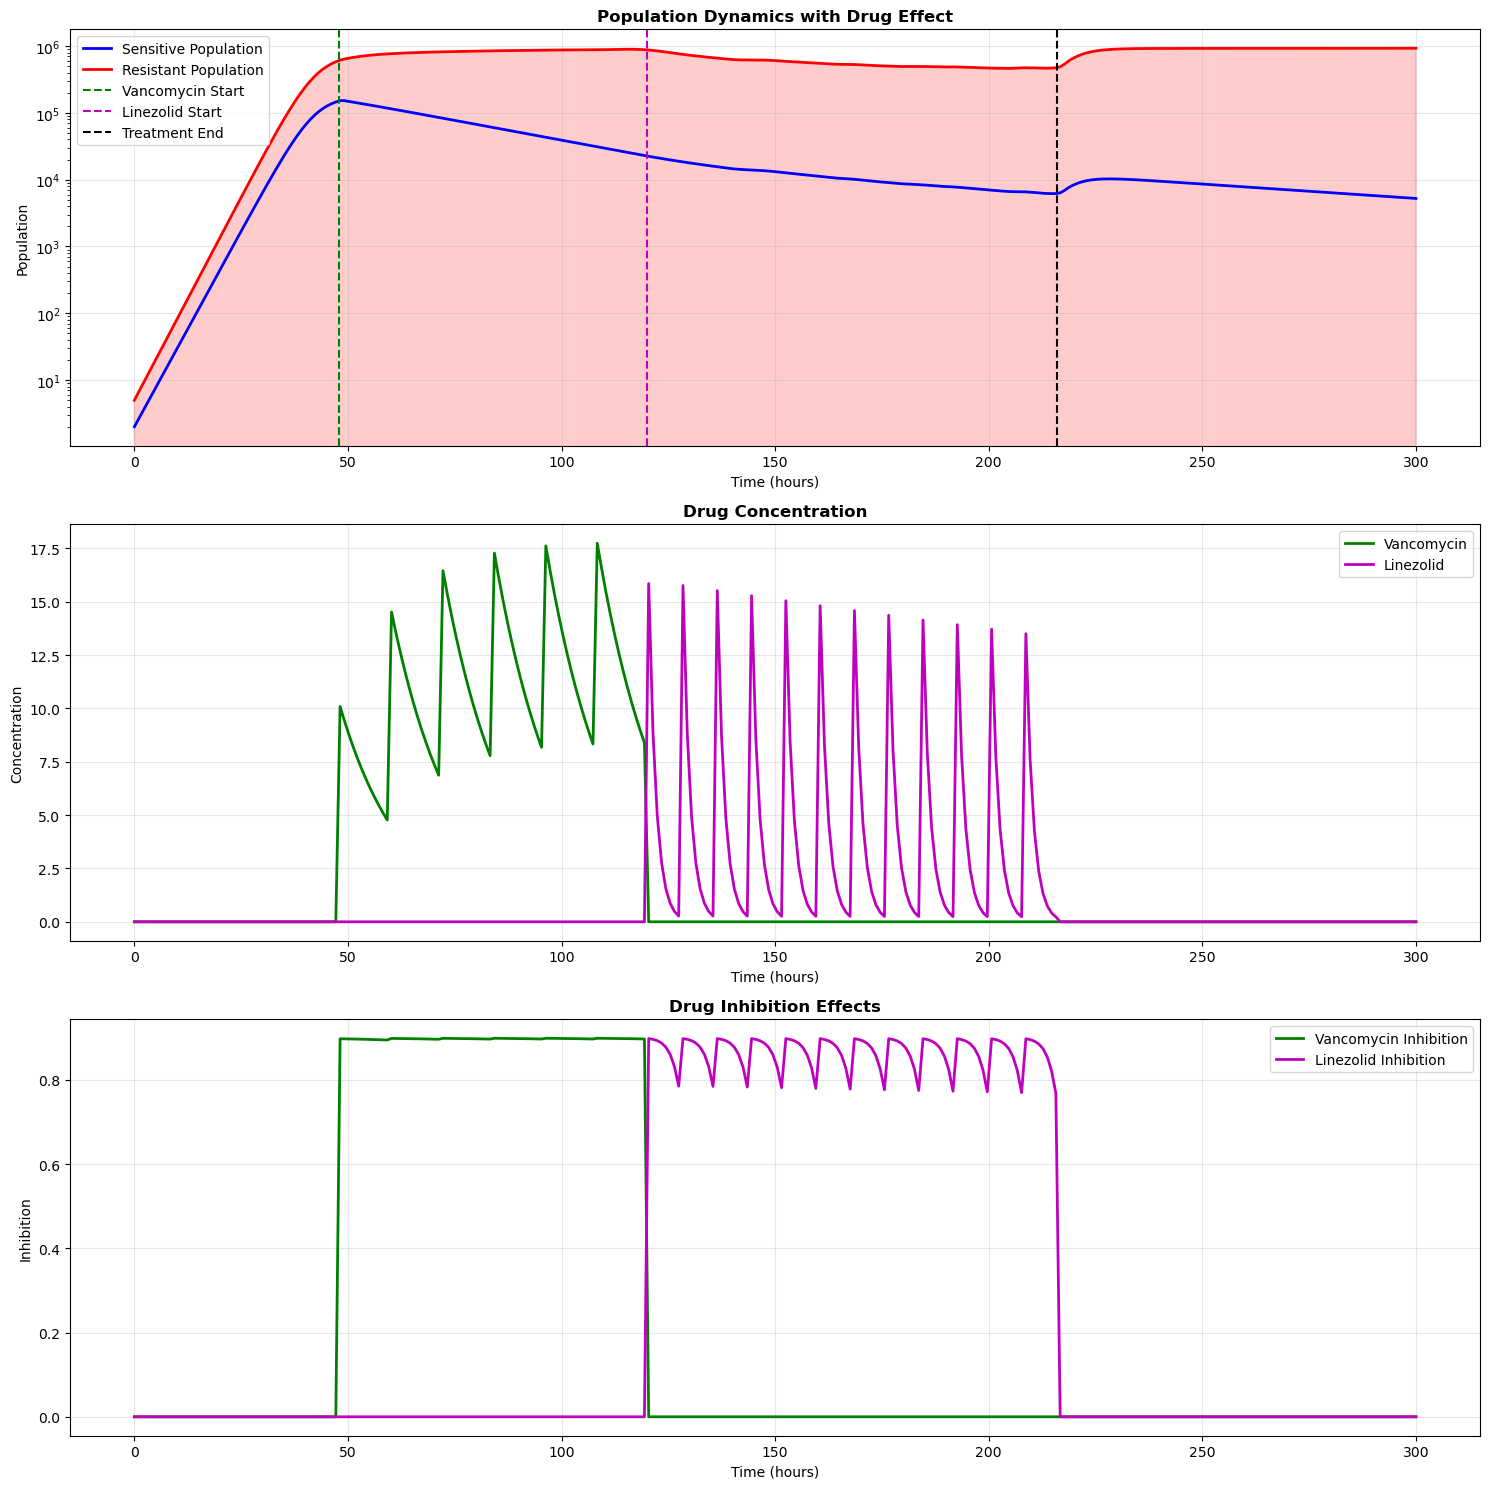

In [115]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt 

def Ke_Vancomycin(sCr, Age, weight, V=49):
    eCCr = (140 - Age)*weight/(72*sCr)
    Vanco_CL = (60*eCCr)/(1000*1.08)  # l/hr
    Kel = (Vanco_CL/V)  # hr-1
    return Kel

def Ke_Linezolid(sCr, Age, weight, V=50):
    CrCL = (140 - Age)*weight/(72*sCr)
    CL_linezolid = 5 + (CrCL * 0.4)
    Kel = CL_linezolid / V
    return Kel

def concentration(t, D, V, Ke, tau, start_time, end_time, dosing_times=None):
    conc = np.zeros_like(t)
    if dosing_times is None:
        dosing_times = np.arange(start_time, end_time, tau)
    
    for i, time_point in enumerate(t):
        if start_time <= time_point <= end_time:
            for dose_time in dosing_times:
                if time_point >= dose_time:
                    conc[i] += (D / V) * np.exp(-Ke * (time_point - dose_time))
    return conc

def simulate_drug_dynamics(
    initial_sensitive=2, 
    initial_resistant=5, 
    no_drug_period=48,
    vancomycin_duration=72,
    linezolid_duration=96,
    total_simulation_time=300
):
    # First, calculate all timing to ensure it fits
    vanco_start = no_drug_period
    vanco_end = vanco_start + vancomycin_duration
    linez_start = vanco_end
    linez_end = linez_start + linezolid_duration
    
    if linez_end > total_simulation_time:
        raise ValueError(f"Total treatment time ({linez_end}h) exceeds simulation time ({total_simulation_time}h)")

    # Patient Specific Parameters
    sCr = 1.3
    Age = 60
    weight = 70
    V_vancomycin = 49
    V_linezolid = 50

    # Calculate Elimination Rates
    Ke_vanco = Ke_Vancomycin(sCr, Age, weight)
    Ke_linez = Ke_Linezolid(sCr, Age, weight)

    # Time Array
    time = np.linspace(0, total_simulation_time, total_simulation_time)

    # Vancomycin Dosing
    D_vancomycin = 500  # mg
    tau_vancomycin = 12  # hours

    # Linezolid Dosing - increased dose for more effect
    D_linezolid = 1000  # mg
    tau_linezolid = 8   # hours

    # Calculate Drug Concentrations
    conc_vancomycin = concentration(
        time, D_vancomycin, V_vancomycin, Ke_vanco, tau_vancomycin, 
        vanco_start, vanco_end
    )
    conc_linezolid = concentration(
        time, D_linezolid, V_linezolid, Ke_linez, tau_linezolid, 
        linez_start, linez_end
    )

    # Population Dynamics Parameters
    rho_sensitive = 0.3
    rho_resistant = 0.3
    k = 10e5  # carry capacity
    EC_50_vanco = 0.03  # EC50 for vancomycin
    EC_50_linez = 0.04  # Lowered EC50 for linezolid to increase sensitivity
    max_drug_effect = 0.9  # Increased maximum drug effect
    delta_sensitive = 0.03
    delta_resistant = 0.02  # Increased death rate for resistant bacteria

    def population_ode(t, r):
        S, R = r
        
        vanco_t = np.interp(t, time, conc_vancomycin)
        linez_t = np.interp(t, time, conc_linezolid)
        
        vanco_inhibition = max_drug_effect * (vanco_t / (vanco_t + EC_50_vanco))
        linez_inhibition = max_drug_effect * (linez_t / (linez_t + EC_50_linez))
        
        # During antibiotic-free period
        if t < vanco_start:
            dSdt = rho_sensitive * S * (1 - (S + R) / k) - delta_sensitive * S
            dRdt = rho_resistant * R * (1 - (S + R) / k) - delta_resistant * R
        
        # During vancomycin treatment
        elif vanco_start <= t < vanco_end:
            dSdt = rho_sensitive * S * (1 - (S + R) / k) * (1 - vanco_inhibition) - delta_sensitive * S
            dRdt = rho_resistant * R * (1 - (S + R) / k) * (1 - 0.2 * vanco_inhibition) - delta_resistant * R
        
        # During linezolid treatment - increased effect on resistant bacteria
        else:
            dSdt = rho_sensitive * S * (1 - (S + R) / k) * (1 - linez_inhibition) - delta_sensitive * S
            # Increased effect on resistant bacteria
            dRdt = (rho_resistant * R * (1 - (S + R) / k) * (1 - 0.95 * linez_inhibition) - 
                   delta_resistant * R * (1 + 0.5 * linez_inhibition))  # Added drug-dependent death term
        
        return [dSdt, dRdt]

    solution = solve_ivp(
        population_ode, 
        [0, total_simulation_time], 
        [initial_sensitive, initial_resistant],
        dense_output=True,
        t_eval=time
    )

    # Calculate drug inhibition effects
    vanco_inhibition = max_drug_effect * (conc_vancomycin / (conc_vancomycin + EC_50_vanco))
    linez_inhibition = max_drug_effect * (conc_linezolid / (conc_linezolid + EC_50_linez))

    plt.figure(figsize=(15, 15))
    
    # Population dynamics plot with enhanced formatting
    plt.subplot(3, 1, 1)
    plt.plot(time, solution.y[0], 'b-', label='Sensitive Population', linewidth=2)
    plt.plot(time, solution.y[1], 'r-', label='Resistant Population', linewidth=2)
    plt.axvline(x=vanco_start, color='g', linestyle='--', label='Vancomycin Start')
    plt.axvline(x=vanco_end, color='m', linestyle='--', label='Linezolid Start')
    plt.axvline(x=linez_end, color='k', linestyle='--', label='Treatment End')
    plt.fill_between(time, solution.y[1], alpha=0.2, color='red')
    plt.title('Population Dynamics with Drug Effect', fontsize=12, fontweight='bold')
    plt.xlabel('Time (hours)', fontsize=10)
    plt.ylabel('Population', fontsize=10)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.yscale('log')

    # Drug concentration plot
    plt.subplot(3, 1, 2)
    plt.plot(time, conc_vancomycin, 'g-', label='Vancomycin', linewidth=2)
    plt.plot(time, conc_linezolid, 'm-', label='Linezolid', linewidth=2)
    plt.title('Drug Concentration', fontsize=12, fontweight='bold')
    plt.xlabel('Time (hours)', fontsize=10)
    plt.ylabel('Concentration', fontsize=10)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)

    # Drug inhibition plot
    plt.subplot(3, 1, 3)
    plt.plot(time, vanco_inhibition, 'g-', label='Vancomycin Inhibition', linewidth=2)
    plt.plot(time, linez_inhibition, 'm-', label='Linezolid Inhibition', linewidth=2)
    plt.title('Drug Inhibition Effects', fontsize=12, fontweight='bold')
    plt.xlabel('Time (hours)', fontsize=10)
    plt.ylabel('Inhibition', fontsize=10)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    
    return solution, time, conc_vancomycin, conc_linezolid, vanco_inhibition, linez_inhibition

# Run the simulation
solution, time, conc_vanco, conc_linez, vanco_inhib, linez_inhib = simulate_drug_dynamics()